In [24]:
%load_ext autoreload
%autoreload 2

import sys         
sys.path.append('./../../src/') 

from signals.utils import parse_nested_feats
from data.ptbxl import load_raw_ptbxl_data, load_data_and_save, PTBXL_PATH, PTBXLDataModule
from signals.ecg import ECGSignal

import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder


TARGET = 'diagnostic_class'
SAMPLING_RATE = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ptbxl_data = load_raw_ptbxl_data(
    fs=SAMPLING_RATE,
    target = TARGET,
)

# create_representations_dataset(splits=['train'], use_multiprocessing=False)

In [60]:
ptbxl_data_module = PTBXLDataModule("whole_signal_features")
ptbxl_data_module.setup()

train_ds = ptbxl_data_module.train_dataloader().dataset[:][0]
val_ds = ptbxl_data_module.val_dataloader().dataset[:][0]
test_ds = ptbxl_data_module.test_dataloader().dataset[:][0]

train_ds = train_ds.view(len(train_ds), -1).numpy()
val_ds = val_ds.view(len(val_ds), -1).numpy()
test_ds = test_ds.view(len(test_ds), -1).numpy()

y_train = ptbxl_data_module.train_dataloader().dataset[:][1]
y_val = ptbxl_data_module.val_dataloader().dataset[:][1]
y_test = ptbxl_data_module.test_dataloader().dataset[:][1]

ptbxl_dataset = {
    'train': {'X': train_ds, 'y': y_train},
    'val': {'X': val_ds, 'y': y_val},
    'test': {'X': test_ds, 'y': y_test},
}

In [66]:
from evaluation.metrics import get_classification_metrics
from evaluation.visualisations import plot_feature_importance, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

model = LGBMClassifier()

X_train = ptbxl_dataset['train']['X']
y_train = ptbxl_dataset['train']['y']

X_val = ptbxl_dataset['val']['X']
y_val = ptbxl_dataset['val']['y']

X_test = ptbxl_dataset['test']['X']
y_test = ptbxl_dataset['test']['y']

model.fit(X_train, y_train)

train_metrics = get_classification_metrics(model.predict_proba(X_train), y_train)
val_metrics = get_classification_metrics(model.predict_proba(X_val), y_val)
test_metrics = get_classification_metrics(model.predict_proba(X_test), y_test)

val_metrics, test_metrics

LGBMClassifier()

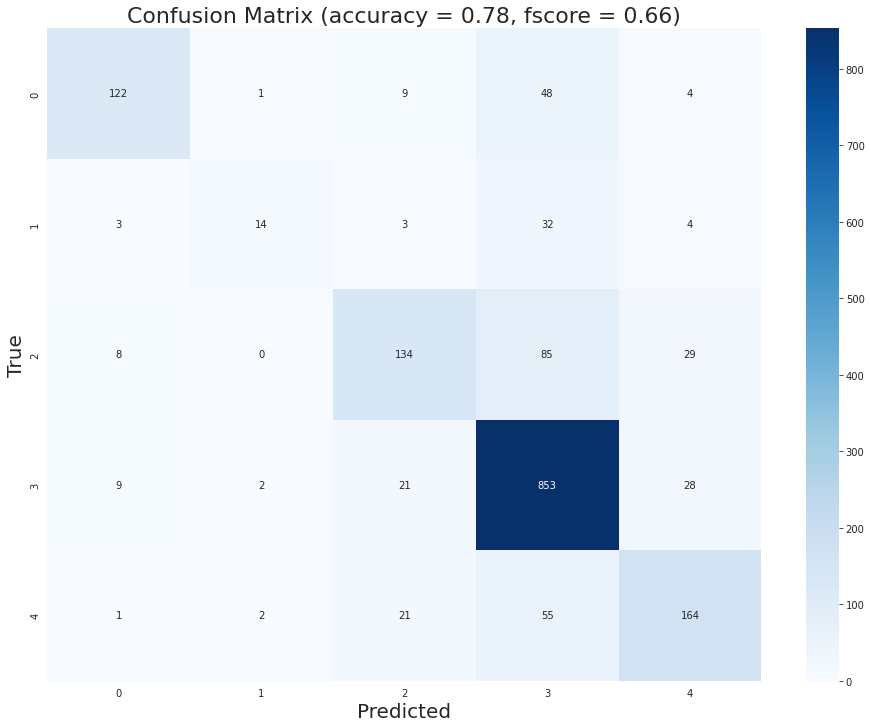

In [340]:
plot_confusion_matrix(y_test, model.predict(X_test), np.unique(y_train))

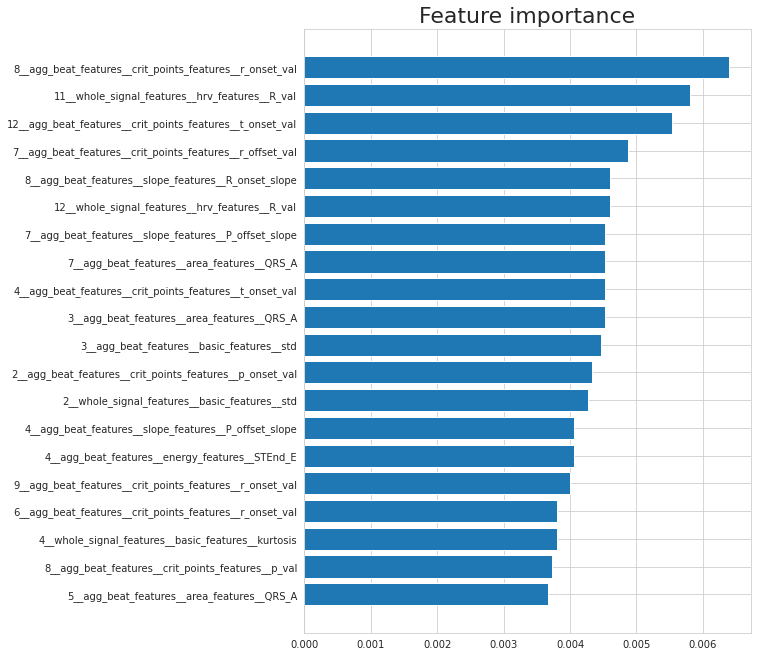

In [341]:
plot_feature_importance(X_train.columns.values, model.feature_importances_, n_best=20)

# Representations:

1. **Whole Signal as TimeSeries. Dimension: `[12 x 1000]`**
    * Samples in time, no processing needed
    
    
2. **Whole Signal as Features. Dimension: `[12 x D]`, where `D` represents number of features extracted from single channel**
    * For each channel extract `D` features:
        * basic features (i.e. `mean`, `std`, `skew`, `kurtosis`)
        * hrv features
        * aggregated beat features:
            * basic features
            * crit points features
            * etc.
        * AC/DC features
    * Features extracted between channels
    
    
3. **Whole Signal as embedding. Dimension: `[12 x D]`, where `D` represents size of embedding for a single channel**
    * Put waveform signals into embedding model and take embeddings as representation
    
    
4. **Per-beat features. Dimension: `[12 x K x D]`, where `K` is number of beats per channel and `D` is number of features extracted from single beat**
    * Beats are obtained from one channel (`source_channel`) and intervals from that channel are used to take beats from other channels
    * For each beat extract features
        * basic features
        * crit points features
        * etc.

In [124]:
def get_beats_from_all_channels(channels, fs=100):
    try:
        multi_ecg = create_multichannel_ecg(channels.T, fs=fs)
        beats = multi_ecg.get_beats(source_channel=2, return_arr=True)
        return beats
    except Exception:
        return None

# multi_ecg_beats_data = Parallel(n_jobs=-1)(delayed(get_beats_from_all_channels)(channels) for channels in tqdm(data))
multi_ecg_beats_data = [get_beats_from_all_channels(channels) for channels in tqdm(data)]
multi_ecg_beats_data = [el for el in multi_ecg_beats_data if el is not None]
num_beats = np.array([el.shape[1] for el in multi_ecg_beats_data])
sns.histplot(num_beats)

  0%|          | 0/12978 [00:00<?, ?it/s]

/home/shate/.local/lib/python3.8/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in true_divide
  mrrs /= th2
/home/shate/.local/lib/python3.8/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in true_divide
  mrrs /= th2
/home/shate/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shate/.local/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:68: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
